In [1]:
!pip install transformers datasets
import numpy as np
import time
import math
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_
from transformers import pipeline, BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from datasets import load_dataset
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00


In [2]:
data = load_dataset("rotten_tomatoes")

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [3]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [4]:
label_names = data["train"].features['label'].names
label_names

['neg', 'pos']

In [5]:
data.set_format(type="pandas")
train = data['train'][:]
valid = data['validation'][:]
test = data['test'][:]

In [6]:
test.head()

,text,label
0,lovingly photographed in the manner of a golde...,1
1,consistently clever and suspenseful .,1
2,"it's like a "" big chill "" reunion of the baade...",1
3,the story gives ample opportunity for large-sc...,1
4,"red dragon "" never cuts corners .",1


## Preprocessing

In [7]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [8]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''

    start_time = time.time()
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']

    end_time = time.time()
    encoding_time = end_time - start_time
    return input_ids, attention_masks, encoding_time

In [9]:
train_input_ids, train_att_masks, train_enc_time = encode(train['text'].values.tolist())
valid_input_ids, valid_att_masks, valid_enc_time = encode(valid['text'].values.tolist())
test_input_ids, test_att_masks, test_enc_time = encode(test['text'].values.tolist())

In [10]:
train_y = torch.LongTensor(train['label'].values.tolist())
valid_y = torch.LongTensor(valid['label'].values.tolist())
test_y = torch.LongTensor(test['label'].values.tolist())

In [11]:
BATCH_SIZE = 16
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

## Fine-tuning

In [12]:
N_labels = len(train.label.unique())
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
EPOCHS = 5
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(
             optimizer,
             num_warmup_steps=0,
             num_training_steps=len(train_dataloader)*EPOCHS)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
model = model.cuda()

In [15]:
start_time = time.time()

train_loss_per_epoch = []
val_loss_per_epoch = []

for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))

    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

end_time = time.time()
train_time = end_time - start_time

Epoch:  1


Training:   0%|          | 0/534 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

534/534 train loss: 0.5286811280730512 
67/67 val loss: 0.4034426967377093 
Epoch:  2


Training:   0%|          | 0/534 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

534/534 train loss: 0.3673822863606478 
67/67 val loss: 0.3629276870346781 
Epoch:  3


Training:   0%|          | 0/534 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

534/534 train loss: 0.32057454870937024 
67/67 val loss: 0.36825543058229915 
Epoch:  4


Training:   0%|          | 0/534 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

534/534 train loss: 0.30026070216203227 
67/67 val loss: 0.36859848783976995 
Epoch:  5


Training:   0%|          | 0/534 [00:00<?, ?it/s]

Validation:   0%|          | 0/67 [00:00<?, ?it/s]

534/534 train loss: 0.28309591874229106 
67/67 val loss: 0.3697920098567187 


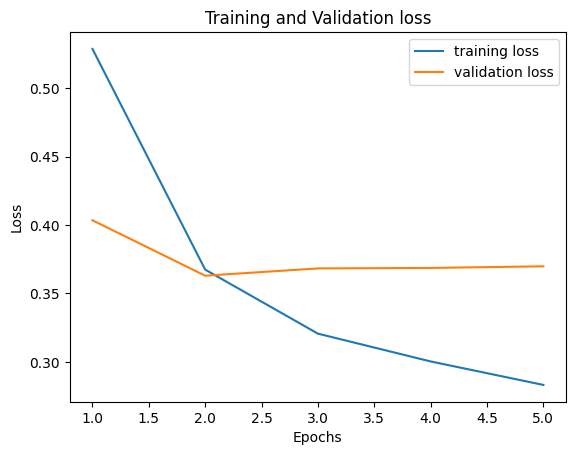

In [16]:
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [17]:
print('classification report')
print(classification_report(valid['label'].to_numpy(), valid_pred, target_names=label_names, digits=4))
print(f"Encoding time: {train_enc_time + valid_enc_time}")
print(f"Training time: {train_time}")
print(f"Total training time: {train_enc_time + valid_enc_time + train_time}")

classification report
              precision    recall  f1-score   support

         neg     0.8613    0.8386    0.8498       533
         pos     0.8428    0.8649    0.8537       533

    accuracy                         0.8518      1066
   macro avg     0.8520    0.8518    0.8518      1066
weighted avg     0.8520    0.8518    0.8518      1066

Encoding time: 7.339048385620117
Training time: 962.657478094101
Total training time: 969.9965264797211


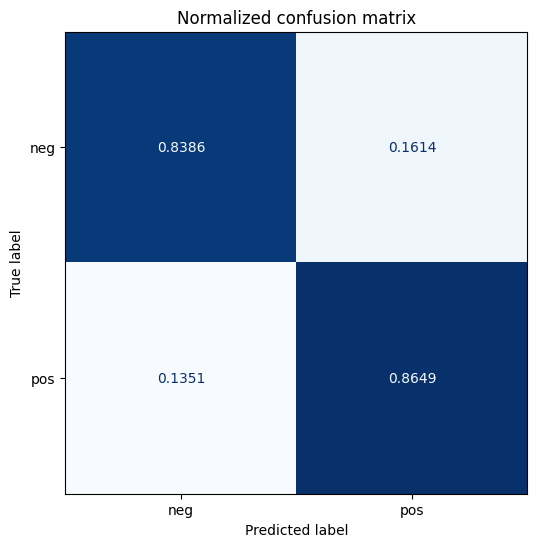

In [18]:
def plot_confusion_matrix( y_true, y_preds, labels=None):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".4f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
plot_confusion_matrix(valid['label'].to_numpy(), valid_pred, labels=label_names)

In [19]:
model.eval()

start_time = time.time()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()

        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)
end_time = time.time()
testing_time =  end_time - start_time
print(testing_time)

0it [00:00, ?it/s]

7.747299671173096


In [20]:
print('classification report')
print(classification_report(test['label'].to_numpy(), test_pred, target_names=label_names, digits=4))
print(f"Encoding time: {test_enc_time}")
print(f"Testing time: {testing_time}")
print(f"Total testing time: {test_enc_time + testing_time}")

classification report
              precision    recall  f1-score   support

         neg     0.8414    0.8462    0.8438       533
         pos     0.8453    0.8405    0.8429       533

    accuracy                         0.8433      1066
   macro avg     0.8434    0.8433    0.8433      1066
weighted avg     0.8434    0.8433    0.8433      1066

Encoding time: 0.5773007869720459
Testing time: 7.747299671173096
Total testing time: 8.324600458145142


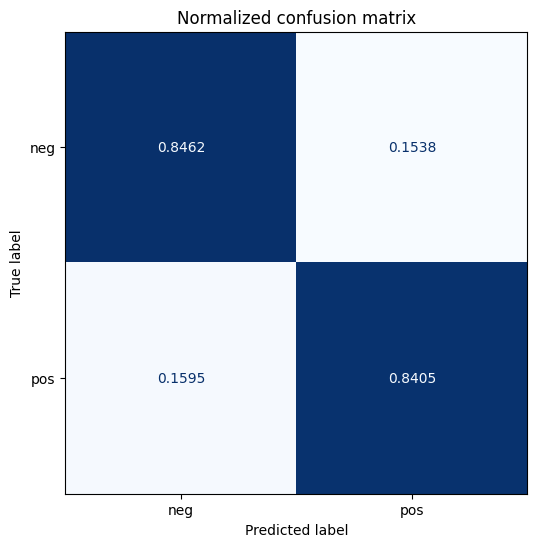

In [21]:
plot_confusion_matrix(test['label'].to_numpy(), test_pred, labels=label_names)